#Import Library

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from glob import glob
import matplotlib.image as img
import zipfile
from tensorflow.keras.callbacks import EarlyStopping

#Dataset

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [5]:
!rm -rf data

In [6]:
! kaggle datasets list

ref                                                            title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                   41MB  2023-11-15 07:32:56            739         72  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset             Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37          29092        563  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT Proper Train Dataset                      119MB  2023-11-05 14:03:25            884        105  1.0              
joebeachcapital/30000-spotify-songs                            30000 Spotify Songs   

In [7]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 99% 593M/601M [00:08<00:00, 73.7MB/s]
100% 601M/601M [00:08<00:00, 73.6MB/s]


#Extract Zip File

In [8]:
local_zip = 'signature-verification-dataset.zip'
target_extraction = '/content/data/'
file_check = "dataset"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)

except FileNotFoundError:
    print('Zip File Not Found!')

# Split Dataset

In [9]:
!mkdir Train
!mkdir Test

!mkdir Train/Fake
!mkdir Train/Real

!mkdir Test/Fake
!mkdir Test/Real

In [10]:
PATH = "/content/data/sign_data/train/"

for i in os.listdir(PATH):

    contol = i.split("_")

    try:

        if contol[1]=="forg":

            os.system("cp -r {} Train/Fake".format(PATH+i))

    except:

        os.system("cp -r {} Train/Real".format(PATH+i))

In [11]:
PATH = "/content/data/sign_data/test/"

for i in os.listdir(PATH):

    contol = i.split("_")

    try:

        if contol[1]=="forg":

            os.system("cp -r {} Test/Fake".format(PATH+i))

    except:

        os.system("cp -r {} Test/Real".format(PATH+i))

In [14]:
train_dir = os.path.join("/content/Train")
test_dir = os.path.join("/content/Test")

In [15]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=64,
        class_mode='binary')

Found 1649 images belonging to 2 classes.


In [24]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=64,
        class_mode='binary')

Found 500 images belonging to 2 classes.


# Parameter

In [25]:
IMG_SIZE = (200,200)
IMG_SHAPE = IMG_SIZE + (3,)

# Architecture

In [27]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SHAPE))),
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu')),
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu')),

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 conv2d_4 (Conv2D)           (None, 196, 196, 32)      4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 194, 194, 16)      4624      
                                                                 
 flatten_1 (Flatten)         (None, 602176)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               77078656  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 77088497 (294.07 MB)
Trainable params: 7

In [28]:
learning_rate = 0.001

model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  metrics=['accuracy'])

# Set Callback

In [30]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.92:
                print("\nReached 92% validation accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

# Training Model

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=30,
    verbose=2, callbacks=[callbacks])

Epoch 1/30
25/25 - 25s - loss: 0.3389 - accuracy: 0.8700 - 25s/epoch - 1s/step
Epoch 2/30
25/25 - 22s - loss: 0.3223 - accuracy: 0.8732 - 22s/epoch - 898ms/step
Epoch 3/30
25/25 - 20s - loss: 0.3145 - accuracy: 0.8808 - 20s/epoch - 817ms/step
Epoch 4/30
25/25 - 23s - loss: 0.3263 - accuracy: 0.8782 - 23s/epoch - 903ms/step
Epoch 5/30
25/25 - 21s - loss: 0.3298 - accuracy: 0.8782 - 21s/epoch - 823ms/step
Epoch 6/30
25/25 - 22s - loss: 0.3228 - accuracy: 0.8700 - 22s/epoch - 885ms/step
Epoch 7/30
25/25 - 22s - loss: 0.3188 - accuracy: 0.8776 - 22s/epoch - 876ms/step
Epoch 8/30
25/25 - 21s - loss: 0.3195 - accuracy: 0.8801 - 21s/epoch - 840ms/step
Epoch 9/30
25/25 - 22s - loss: 0.2997 - accuracy: 0.8852 - 22s/epoch - 882ms/step
Epoch 10/30
25/25 - 21s - loss: 0.3032 - accuracy: 0.8858 - 21s/epoch - 853ms/step
Epoch 11/30
25/25 - 22s - loss: 0.3103 - accuracy: 0.8909 - 22s/epoch - 877ms/step
Epoch 12/30
25/25 - 21s - loss: 0.3030 - accuracy: 0.8890 - 21s/epoch - 823ms/step
Epoch 13/30
25/2

# Model Evaluate

In [34]:
model.evaluate(test_generator)

8/8 [==============================] - 3s 343ms/step - loss: 0.2252 - accuracy: 0.9380


[0.22519539296627045, 0.9380000233650208]

Text(0.5, 1.0, 'Training Loss')

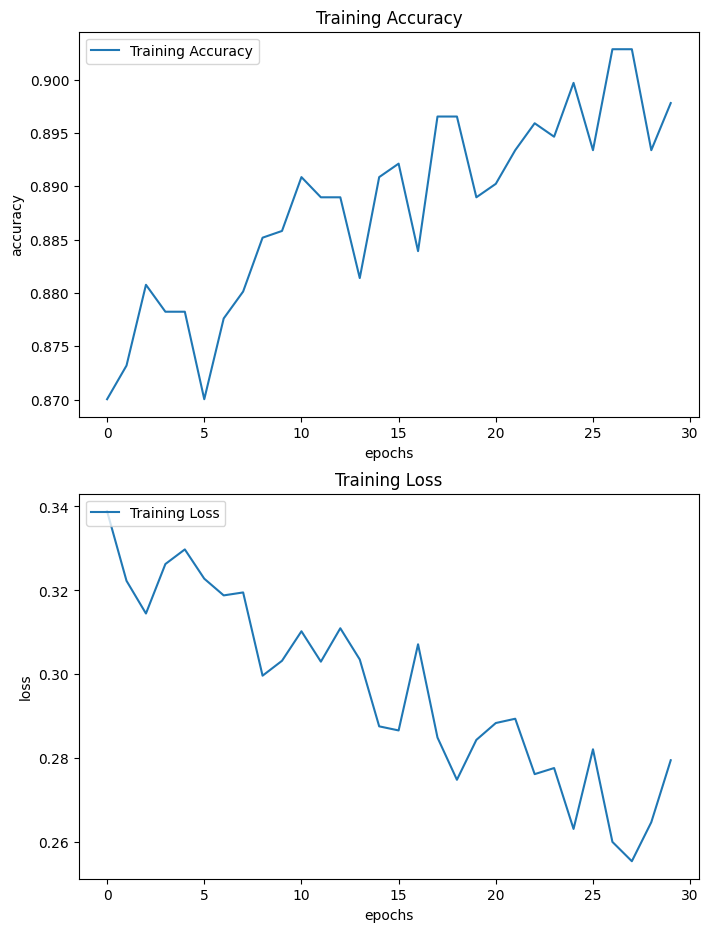

In [38]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 11))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training Loss')